In [1]:
import os
import sys
import gc
import pickle
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
from typing import *
from tqdm.notebook import tqdm
from pathlib import Path
from matplotlib import pyplot as plt

pd.set_option('max_columns', 50)
pd.set_option('max_rows', 200)
warnings.simplefilter('ignore')
sns.set()

In [2]:
base_dir = Path().resolve()
sys.path.append(str(base_dir / '../'))

from utils.preprocess import *
from utils.model import *
from utils.train import *
from utils.eval import *
from utils.detectron2helper import *

fail to import apex_C: apex was not installed or installed without --cpp_ext.
fail to import amp_C: apex was not installed or installed without --cpp_ext.
** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



HACKING: overriding COCOeval.summarize = vin_summarize...


In [3]:
def seed_everything(seed: int, device: str):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    with torch.cuda.device(device):
        torch.cuda.empty_cache()

In [4]:
base_dir = Path().resolve()


classes_nms = [
    "Aortic enlargement",
    "Atelectasis",
    "Calcification",
    "Cardiomegaly",
    "Consolidation",
    "ILD",
    "Infiltration",
    "Lung Opacity",
    "Nodule/Mass",
    "Other lesion",
    "Pleural effusion",
    "Pleural thickening",
    "Pneumothorax",
    "Pulmonary fibrosis",
#     "No Finding"
]
classes_dict = {index: class_name  for index, class_name in enumerate(classes_nms)}

In [5]:
def load(mkf, dataset_dicts, train, result_dirname):
    N_SPLITS = 5
    
    pred_df_list, evaluator_list = list(), list()
    for fold in range(N_SPLITS):
        _, valid_df = mkf[fold]
        valid_idx = list(pd.DataFrame({'image_id': [dd['image_id'] for dd in dataset_dicts]}).query(f"image_id in {valid_df['image_id'].values.tolist()}").index)
        evaluator_list += [VinBigDataEval(train.query(f"image_id in {[dd['image_id'] for dd in [dataset_dicts[i] for i in valid_idx]]}"))]
        pred_df_list += [pd.read_csv(base_dir / 'detectron2_results' / result_dirname / f'fold-{fold + 1}' / 'validation.csv')]
    
    return pred_df_list, evaluator_list

In [17]:
from ensemble_boxes import *

def nms_by_class(
    boxes: np.ndarray, scores: np.ndarray, labels: np.ndarray, cls_id: int, iou_thr: float, skip_box_thr: float
) -> Tuple[List[List[float]], List[float], List[int]]:
    
    mask = (labels == cls_id)
    if mask.sum() == 1:
        return boxes[mask, :], scores[mask], labels[mask]
    else:
#         return nms(
#             [boxes[mask, :].tolist()],
#             [scores[mask].tolist()],
#             [labels[mask].tolist()],
#             weights=None, 
#             iou_thr=iou_thr,
#         )
        return weighted_boxes_fusion(
                [boxes[mask, :].tolist()],
                [scores[mask].tolist()],
                [labels[mask].tolist()],
                weights=None, 
                iou_thr=iou_thr,
                skip_box_thr=skip_box_thr
            )

In [18]:
def evaluate_mAP(pred_df_list, evaluator_list, cls_id, iou_thr, skip_box_thr, img_size):
    mAPs = list()
    for pred_df, evaluator in tqdm(zip(pred_df_list, evaluator_list)):
        records = {'image_id': list(), 'PredictionString': list()}

        for i in range(len(pred_df)):
            image_id, f_pred_str = pred_df.loc[i]

            objs = np.array(f_pred_str.split(' ')).reshape(-1, 6)
            f_boxes = objs[:, 2:].astype(float)
            f_boxes[:, [0, 2]] /= img_size
            f_boxes[:, [1, 3]] /= img_size
            f_labels = objs[:, 0].astype(int)
            f_scores = objs[:, 1].astype(float)

            if (f_labels == cls_id).sum() == 0:
                records['image_id'] += [image_id]
                records['PredictionString'] += ['']
                continue

            c_boxes, c_scores, c_labels = nms_by_class(
                boxes=f_boxes,
                scores=f_scores,
                labels=f_labels,
                cls_id=cls_id,
                iou_thr=iou_thr,
                skip_box_thr=skip_box_thr,
            )

            c_boxes = np.array(c_boxes)
            c_boxes[:, [0, 2]] *= img_size
            c_boxes[:, [1, 3]] *= img_size

            c_boxes = c_boxes.tolist()
            c_scores = c_scores.tolist()
            c_labels = c_labels.tolist()

            pred_str = list()
            for label, score, box in zip(c_labels, c_scores, c_boxes):
                pred_str += [str(int(label))] + [str(score)] + np.array(box).astype(str).tolist()

            records['image_id'] += [image_id]
            records['PredictionString'] += [' '.join(pred_str)]

        
        p_pred_df = pd.DataFrame(records)
        mAPs += [evaluator.evaluate(p_pred_df, category_ids=[cls_id]).stats[0]]
    return mAPs

In [26]:
def evaluate_by_class(pred_df_list, evaluator_list, img_size, cls_ids, iou_thrs, skip_box_thrs):
    results = list()
    for cls_id in cls_ids:
        cls_results = list()
        cls_skip_box_thr = 0.
        for cls_iou_thr in iou_thrs:
            cls_sb_results = list()
            for cls_skip_box_thr in skip_box_thrs:
                cls_sb_results += [evaluate_mAP(pred_df_list, evaluator_list, cls_id, cls_iou_thr, cls_skip_box_thr, img_size)]
            cls_results += [cls_sb_results]

        results += [cls_results]        
    return results

In [27]:
# result_dirs = [f for f in sorted(os.listdir(base_dir / 'detectron2_results')) if f not in ['.ipynb_checkpoints', 'results00', 'results01', 'results02', '__256', 'results00-unknown']]
# result_dirs = result_dirs[:3]
result_dirs = ['retinanet_R_101_FPN_3x_mkf_5_1024']
result_dirs

['retinanet_R_101_FPN_3x_mkf_5_1024']

In [28]:
iou_thrs = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
skip_box_thrs = [0., 0.05, 0.1, 0.2]

results_by_models = {'model_dir': list(), 'results': list()}

for result_dir in tqdm(result_dirs):
    rm = ('rm' in result_dir)

    if '256' in result_dir:
        img_size = 256
    elif '512' in result_dir:
        img_size = 512
    elif '1024' in result_dir:
        img_size = 1024
    else:
        raise ValueError()

    if 'nms01' in result_dir:
        iou_thr = 0.1
    else:
        iou_thr = 0.5

    print(rm, img_size, iou_thr)
    
    rm_str = '_rm' if rm else ''
    train = pickle.load(open(str(base_dir / f'nms{iou_thr}_train_{img_size}{rm_str}.pkl'), 'rb'))
    dataset_dicts = pickle.load(open(str(base_dir / f'nms{iou_thr}_dataset_dicts_{img_size}{rm_str}.pkl'), 'rb'))
    mkf = pickle.load(open(str(base_dir / f'nms{iou_thr}_mkf_{img_size}{rm_str}.pkl'), 'rb'))
    
    results_by_models['model_dir'] += [result_dir]    
    pred_df_list, evaluator_list = load(mkf, dataset_dicts, train, result_dir)
#     results_by_models['results'] += [[evaluator.evaluate(pred_df).stats[0] for pred_df, evaluator in zip(pred_df_list, evaluator_list)]]
    results_by_models['results'] += [evaluate_by_class(pred_df_list, evaluator_list, img_size, list(range(len(classes_nms))), iou_thrs, skip_box_thrs)]

  0%|          | 0/1 [00:00<?, ?it/s]

False 1024 0.5
Generating image data...
Generating category data...
Generating annotation data...
Generating image data...
Generating category data...
Generating annotation data...
Generating image data...
Generating category data...
Generating annotation data...
Generating image data...
Generating category data...
Generating annotation data...
Generating image data...
Generating category data...
Generating annotation data...


0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.44s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.723
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.723
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.844
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.744
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.908
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.912
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.912
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.723
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.723
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.844
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.744
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.908
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.912
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.912
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.43s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.789
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.789
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.903
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.811
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.909
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.911
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.911
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.831
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.831
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.914
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.861
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.908
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.909
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.909
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.727
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.727
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.846
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.753
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.908
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.920
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.920
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.727
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.727
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.846
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.753
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.908
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.920
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.920
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.790
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.790
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.906
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.812
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.909
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.912
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.912
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.831
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.831
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.914
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.861
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.908
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.909
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.909
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.757
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.757
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.875
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.783
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.908
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.939
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.939
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.757
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.757
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.875
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.783
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.908
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.939
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.939
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.805
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.805
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.913
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.826
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.909
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.929
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.929
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.839
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.839
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.914
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.862
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.908
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.911
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.911
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.807
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.807
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.898
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.827
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.908
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.969
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.969
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.807
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.807
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.898
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.827
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.908
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.969
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.969
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.838
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.838
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.926
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.857
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.909
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.960
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.960
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.45s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.849
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.849
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.925
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.872
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.908
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.924
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.924
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.846
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.846
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.894
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.860
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.909
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.991
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.991
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.846
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.846
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.894
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.860
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.909
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.991
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.991
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.861
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.861
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.915
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.878
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.909
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.982
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.982
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.862
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.862
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.930
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.878
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.908
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.933
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.933
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.906
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.906
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.939
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.921
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.909
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.996
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.996
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.906
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.906
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.939
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.921
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.909
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.996
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.996
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.47s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.908
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.908
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.944
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.922
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.909
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.991
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.991
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.896
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.896
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.949
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.918
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.908
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.960
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.960
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.913
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.913
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.949
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.927
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.909
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.996
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.996
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.17s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.913
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.913
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.949
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.927
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.909
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.996
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.996
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.913
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.913
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.949
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.927
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.909
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.991
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.991
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.44s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.896
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.896
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.949
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.918
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.908
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.960
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.960
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.320
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.320
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.333
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.646
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.708
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.708
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.320
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.320
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.333
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.646
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.708
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.708
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.315
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.315
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.329
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.604
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.667
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.667
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.389
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.389
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.405
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.583
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.604
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.604
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.315
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.315
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.328
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.625
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.708
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.708
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.315
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.315
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.328
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.625
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.708
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.708
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.310
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.310
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.324
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.583
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.667
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.667
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.388
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.388
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.405
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.562
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.604
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.604
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.320
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.320
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.333
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.625
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.729
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.729
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.320
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.320
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.333
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.625
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.729
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.729
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.316
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.316
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.330
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.583
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.688
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.688
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.380
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.380
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.396
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.562
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.604
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.604
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.34s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.341
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.341
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.022
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.355
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.625
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.750
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.750
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.341
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.341
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.022
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.355
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.625
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.750
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.750
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.337
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.337
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.352
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.583
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.708
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.708
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.363
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.363
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.378
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.562
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.604
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.604
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.334
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.334
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.022
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.347
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.604
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.854
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.854
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.334
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.334
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.022
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.347
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.604
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.854
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.854
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.329
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.329
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.344
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.562
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.792
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.792
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.320
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.320
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.334
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.562
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.625
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.625
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.366
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.366
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.019
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.379
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.625
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.896
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.896
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.366
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.366
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.019
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.379
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.625
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.896
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.896
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.363
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.363
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.377
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.583
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.833
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.833
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.350
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.350
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.366
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.562
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.646
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.646
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.377
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.377
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.019
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.391
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.625
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.896
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.896
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.37s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.377
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.377
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.019
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.391
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.625
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.896
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.896
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.374
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.374
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.390
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.583
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.833
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.833
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.350
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.350
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.366
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.562
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.646
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.646
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.256
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.256
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.226
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.300
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.431
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.463
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.762
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.762
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.256
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.256
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.226
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.300
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.431
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.463
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.762
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.762
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.09s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.273
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.273
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.276
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.319
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.469
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.475
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.750
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.750
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.290
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.290
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.329
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.427
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.406
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.562
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.562
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.272
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.272
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.191
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.314
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.448
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.469
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.812
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.812
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.272
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.272
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.191
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.314
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.448
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.469
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.812
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.812
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.280
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.280
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.319
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.481
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.481
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.794
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.794
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.297
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.297
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.229
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.333
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.456
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.406
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.588
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.588
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.307
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.307
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.190
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.356
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.467
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.487
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.844
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.844
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.307
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.307
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.190
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.356
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.467
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.487
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.844
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.844
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.303
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.303
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.234
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.337
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.468
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.487
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.825
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.825
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.303
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.303
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.224
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.332
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.445
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.406
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.600
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.600
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.314
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.314
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.195
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.348
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.496
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.481
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.844
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.856
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.314
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.314
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.195
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.348
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.496
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.481
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.844
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.856
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.299
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.299
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.229
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.330
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.460
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.487
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.825
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.831
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.300
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.300
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.222
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.323
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.443
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.406
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.619
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.619
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.328
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.328
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.333
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.487
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.481
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.850
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.869
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.328
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.328
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.333
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.487
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.481
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.850
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.869
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.41s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.320
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.320
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.243
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.327
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.471
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.487
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.844
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.856
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.314
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.314
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.220
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.326
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.459
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.406
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.637
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.637
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.343
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.343
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.226
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.351
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.492
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.494
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.838
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.875
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.343
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.343
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.226
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.351
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.492
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.494
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.838
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.875
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.343
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.343
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.225
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.350
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.492
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.494
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.831
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.863
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.314
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.314
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.184
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.318
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.469
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.406
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.631
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.650
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.343
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.343
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.224
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.353
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.492
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.487
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.838
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.875
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.343
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.343
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.224
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.353
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.492
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.487
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.838
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.875
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.342
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.342
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.223
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.353
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.492
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.487
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.831
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.863
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.313
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.313
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.184
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.317
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.469
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.406
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.631
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.650
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.41s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.658
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.658
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.658
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.952
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.952
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.952
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= 

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.658
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.658
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.658
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.952
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.952
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.952
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= 

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.811
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.811
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.811
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.952
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.952
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.952
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= 

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.877
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.877
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.877
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.950
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.950
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.950
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= 

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.655
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.655
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.656
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.948
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.952
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.952
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= 

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.655
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.655
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.656
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.948
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.952
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.952
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= 

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.811
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.811
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.811
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.948
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.952
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.952
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= 

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.877
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.877
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.877
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.948
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.950
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.950
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= 

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.656
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.656
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.656
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.948
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.952
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.952
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= 

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.656
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.656
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.656
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.948
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.952
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.952
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= 

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.812
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.812
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.812
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.948
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.952
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.952
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= 

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.877
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.877
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.877
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.948
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.950
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.950
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= 

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.657
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.657
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.658
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.948
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.954
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.954
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= 

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.657
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.657
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.658
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.948
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.954
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.954
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= 

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.814
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.814
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.814
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.948
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.952
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.952
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= 

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.877
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.877
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.877
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.948
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.950
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.950
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= 

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.687
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.687
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.687
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.948
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.971
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.971
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= 

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.687
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.687
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.687
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.948
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.971
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.971
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= 

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.823
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.823
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.823
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.948
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.961
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.961
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= 

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.31s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.878
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.878
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.878
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.948
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.950
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.950
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= 

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.17s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.884
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.884
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.884
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.948
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.992
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.992
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= 

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.17s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.884
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.884
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.884
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.948
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.992
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.992
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= 

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.887
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.887
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.887
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.948
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.973
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.973
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= 

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.882
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.882
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.882
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.948
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.952
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.952
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= 

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.893
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.893
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.893
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.948
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.992
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.992
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= 

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.893
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.893
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.893
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.948
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.992
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.992
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= 

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.889
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.889
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.889
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.948
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.973
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.973
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= 

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.882
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.882
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.882
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.948
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.952
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.952
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= 

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.260
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.260
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.179
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.301
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.649
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.713
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.713
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.260
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.260
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.179
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.301
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.649
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.713
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.713
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.267
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.267
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.155
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.316
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.649
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.713
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.713
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.268
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.268
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.145
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.309
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.564
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.606
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.606
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.268
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.268
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.190
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.295
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.649
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.745
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.745
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.268
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.268
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.190
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.295
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.649
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.745
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.745
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.279
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.279
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.152
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.314
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.649
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.745
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.745
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.171
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.314
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.564
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.628
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.628
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.289
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.289
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.166
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.322
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.660
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.777
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.777
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.289
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.289
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.166
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.322
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.660
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.777
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.777
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.297
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.297
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.129
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.342
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.660
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.777
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.777
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.278
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.278
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.166
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.315
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.564
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.638
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.638
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.349
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.349
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.279
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.391
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.649
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.830
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.830
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.349
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.349
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.279
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.391
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.649
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.830
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.830
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.349
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.349
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.406
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.649
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.830
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.830
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.313
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.313
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.165
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.350
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.564
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.691
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.691
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.340
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.340
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.270
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.384
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.638
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.883
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.883
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.340
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.340
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.270
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.384
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.638
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.883
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.883
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.342
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.342
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.184
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.397
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.638
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.883
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.883
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.341
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.341
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.165
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.383
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.564
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.723
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.723
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.360
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.360
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.221
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.396
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.638
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.904
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.904
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.360
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.360
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.221
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.396
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.638
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.904
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.904
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.366
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.366
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.221
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.403
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.638
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.904
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.904
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.350
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.350
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.213
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.387
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.553
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.755
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.755
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.370
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.370
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.219
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.407
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.638
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.904
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.904
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.370
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.370
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.219
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.407
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.638
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.904
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.904
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.370
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.370
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.219
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.407
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.638
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.904
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.904
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.352
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.352
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.213
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.387
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.553
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.755
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.755
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.327
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.327
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.048
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.328
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.455
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.772
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.772
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.327
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.327
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.048
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.328
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.455
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.772
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.772
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.09s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.324
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.324
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.077
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.326
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.462
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.759
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.759
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.387
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.387
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.393
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.386
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.634
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.634
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.320
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.320
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.323
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.455
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.786
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.786
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.320
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.320
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.323
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.455
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.786
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.786
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.09s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.320
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.320
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.048
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.321
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.462
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.772
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.772
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.384
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.384
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.389
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.386
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.634
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.634
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.349
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.349
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.048
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.351
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.448
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.821
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.821
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.349
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.349
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.048
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.351
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.448
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.821
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.821
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.09s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.349
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.349
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.042
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.354
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.455
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.807
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.807
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.394
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.394
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.399
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.386
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.648
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.648
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.360
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.360
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.045
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.362
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.455
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.883
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.883
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.360
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.360
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.045
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.362
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.455
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.883
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.883
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.09s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.372
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.372
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.040
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.376
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.462
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.862
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.862
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.398
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.398
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.403
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.393
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.662
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.662
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.383
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.383
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.040
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.385
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.448
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.910
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.910
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.383
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.383
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.040
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.385
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.448
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.910
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.910
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.403
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.403
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.036
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.407
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.448
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.890
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.890
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.415
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.415
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.421
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.379
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.697
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.697
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.445
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.445
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.033
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.450
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.448
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.938
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.938
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.445
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.445
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.033
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.450
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.448
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.938
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.938
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.445
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.445
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.033
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.451
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.441
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.917
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.917
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.423
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.423
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.430
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.372
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.738
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.738
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.443
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.443
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.033
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.449
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.448
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.938
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.938
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.45s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.443
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.443
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.033
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.449
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.448
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.938
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.938
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.442
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.442
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.033
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.448
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.441
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.917
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.917
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.421
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.421
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.427
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.372
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.738
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.738
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.355
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.355
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.322
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.369
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.587
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.864
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.864
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.355
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.355
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.322
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.369
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.587
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.864
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.864
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.399
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.399
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.363
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.411
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.587
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.848
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.848
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.442
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.442
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.505
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.450
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.527
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.701
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.701
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.359
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.359
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.254
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.381
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.592
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.875
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.875
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.359
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.359
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.254
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.381
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.592
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.875
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.875
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.09s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.399
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.399
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.309
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.418
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.592
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.859
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.859
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.442
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.442
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.482
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.451
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.522
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.701
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.701
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.360
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.360
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.195
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.383
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.603
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.908
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.908
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.360
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.360
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.195
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.383
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.603
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.908
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.908
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.400
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.400
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.237
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.422
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.598
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.891
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.891
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.441
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.441
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.444
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.452
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.522
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.701
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.701
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.365
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.365
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.304
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.381
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.598
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.929
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.929
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.365
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.365
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.304
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.381
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.598
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.929
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.929
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.39s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.396
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.396
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.333
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.413
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.592
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.913
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.913
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.446
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.446
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.457
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.460
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.522
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.717
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.717
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.17s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.410
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.410
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.343
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.427
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.598
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.940
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.940
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.43s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.410
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.410
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.343
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.427
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.598
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.940
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.940
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.436
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.436
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.406
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.447
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.592
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.924
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.924
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.457
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.457
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.452
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.472
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.522
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.728
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.728
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.44s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.516
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.516
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.458
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.531
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.598
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.946
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.946
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.516
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.516
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.458
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.531
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.598
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.946
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.946
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.41s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.514
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.514
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.455
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.529
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.592
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.929
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.929
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.496
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.496
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.458
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.512
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.527
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.761
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.761
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.526
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.526
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.485
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.543
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.598
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.946
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.946
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.526
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.526
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.485
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.543
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.598
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.946
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.946
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.525
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.525
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.485
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.541
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.592
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.929
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.929
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.497
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.497
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.458
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.514
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.533
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.766
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.766
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.311
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.311
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.177
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.249
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.360
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.506
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.775
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.775
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.311
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.311
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.177
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.249
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.360
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.506
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.775
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.775
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.328
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.328
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.172
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.282
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.374
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.504
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.752
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.752
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.335
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.335
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.191
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.234
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.382
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.458
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.591
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.591
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.45s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.300
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.300
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.181
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.373
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.494
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.803
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.803
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.300
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.300
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.167
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.181
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.373
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.494
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.803
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.803
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.324
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.324
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.189
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.214
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.394
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.494
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.783
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.783
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.340
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.340
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.173
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.207
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.393
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.450
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.611
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.611
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.312
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.312
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.179
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.186
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.380
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.501
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.854
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.854
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.312
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.312
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.179
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.186
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.380
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.501
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.854
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.854
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.339
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.339
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.177
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.223
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.403
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.499
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.826
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.826
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.354
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.354
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.173
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.214
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.407
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.450
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.632
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.632
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.346
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.346
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.298
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.205
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.412
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.506
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.908
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.908
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.346
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.346
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.298
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.205
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.412
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.506
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.908
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.908
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.47s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.279
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.233
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.439
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.501
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.882
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.882
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.366
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.366
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.173
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.211
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.422
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.448
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.665
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.665
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.355
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.355
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.303
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.199
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.421
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.509
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.926
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.926
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.355
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.355
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.303
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.199
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.421
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.509
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.926
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.926
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.381
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.381
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.295
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.220
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.449
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.501
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.903
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.903
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.09s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.378
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.378
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.173
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.213
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.434
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.455
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.696
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.696
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.17s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.441
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.441
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.266
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.273
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.497
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.524
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.918
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.931
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.17s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.441
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.441
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.266
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.273
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.497
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.524
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.918
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.931
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.444
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.444
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.259
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.272
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.501
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.524
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.900
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.910
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.09s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.421
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.421
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.103
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.226
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.488
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.460
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.737
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.737
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.18s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.450
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.450
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.206
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.278
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.507
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.532
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.916
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.931
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.17s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.450
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.450
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.206
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.278
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.507
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.532
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.916
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.931
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.449
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.449
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.199
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.506
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.529
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.898
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.910
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.09s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.424
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.424
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.103
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.236
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.489
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.463
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.737
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.737
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.252
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.252
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.217
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.401
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.315
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.310
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.719
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.722
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.252
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.252
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.217
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.401
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.315
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.310
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.719
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.722
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.274
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.274
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.229
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.399
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.400
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.316
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.687
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.690
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.322
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.322
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.297
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.419
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.429
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.307
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.497
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.497
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.262
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.262
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.228
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.386
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.353
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.318
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.778
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.786
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.262
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.262
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.228
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.386
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.353
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.318
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.778
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.786
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.44s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.282
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.282
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.243
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.391
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.413
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.316
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.746
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.754
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.323
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.323
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.289
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.425
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.442
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.305
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.513
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.513
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.282
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.282
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.246
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.409
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.371
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.316
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.799
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.810
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.282
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.282
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.246
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.409
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.371
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.316
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.799
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.810
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.294
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.294
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.259
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.404
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.412
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.313
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.767
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.775
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.325
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.325
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.291
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.430
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.445
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.305
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.516
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.519
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.46s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.297
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.297
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.419
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.362
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.318
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.810
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.829
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.297
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.297
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.419
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.362
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.318
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.810
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.829
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.305
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.305
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.288
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.407
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.400
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.316
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.775
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.791
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.328
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.328
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.303
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.432
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.432
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.305
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.521
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.524
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.330
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.330
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.314
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.464
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.383
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.329
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.824
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.845
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.47s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.330
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.330
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.314
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.464
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.383
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.329
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.824
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.845
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.337
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.337
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.316
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.454
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.423
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.326
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.791
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.810
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.334
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.334
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.313
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.445
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.426
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.305
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.529
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.535
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.393
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.393
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.350
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.519
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.479
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.329
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.824
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.866
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.393
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.393
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.350
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.519
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.479
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.329
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.824
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.866
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.35s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.392
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.392
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.354
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.516
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.478
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.326
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.799
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.840
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.341
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.341
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.321
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.446
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.431
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.302
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.543
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.548
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.20s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.398
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.398
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.364
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.523
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.479
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.329
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.824
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.869
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.398
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.398
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.364
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.523
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.479
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.329
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.824
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.869
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.396
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.396
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.362
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.523
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.477
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.329
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.799
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.842
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.344
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.344
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.322
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.449
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.431
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.302
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.545
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.551
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.099
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.099
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.216
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.085
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.119
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.297
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.649
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.654
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.17s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.099
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.099
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.216
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.085
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.119
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.297
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.649
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.654
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.100
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.100
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.212
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.082
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.120
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.289
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.594
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.600
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.078
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.078
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.091
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.055
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.103
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.194
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.249
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.249
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.49s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.113
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.113
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.205
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.071
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.154
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.271
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.737
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.743
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.113
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.113
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.205
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.071
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.154
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.271
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.737
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.743
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.118
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.118
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.218
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.076
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.159
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.297
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.683
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.689
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.084
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.084
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.077
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.051
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.122
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.206
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.263
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.263
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.119
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.119
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.197
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.068
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.173
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.283
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.786
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.797
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.119
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.119
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.197
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.068
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.173
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.283
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.786
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.797
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.125
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.125
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.212
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.070
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.176
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.309
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.723
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.734
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.38s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.091
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.091
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.077
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.049
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.137
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.206
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.277
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.277
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.127
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.127
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.223
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.066
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.181
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.286
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.794
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.826
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.49s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.127
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.127
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.223
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.066
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.181
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.286
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.794
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.826
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.232
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.071
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.186
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.303
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.737
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.760
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.091
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.091
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.073
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.048
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.138
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.206
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.277
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.280
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.17s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.137
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.137
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.205
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.069
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.189
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.317
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.806
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.840
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.137
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.137
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.205
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.069
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.189
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.317
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.806
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.840
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.143
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.143
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.189
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.076
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.193
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.309
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.751
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.777
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.102
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.102
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.073
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.050
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.152
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.206
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.289
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.294
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.18s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.152
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.152
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.180
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.088
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.195
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.340
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.803
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.860
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.18s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.152
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.152
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.180
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.088
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.195
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.340
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.803
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.860
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.150
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.150
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.173
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.084
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.195
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.334
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.749
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.800
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.106
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.106
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.063
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.048
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.147
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.209
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.283
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.294
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.18s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.158
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.158
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.178
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.089
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.204
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.343
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.803
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.860
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.18s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.158
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.158
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.178
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.089
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.204
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.343
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.803
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.860
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.156
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.156
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.173
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.085
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.202
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.337
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.749
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.800
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.109
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.109
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.063
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.048
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.153
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.209
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.286
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.294
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.472
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.472
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.804
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.462
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.552
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.503
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.687
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.687
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.472
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.472
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.804
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.462
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.552
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.503
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.687
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.687
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.09s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.471
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.471
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.632
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.438
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.559
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.514
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.682
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.682
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.533
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.533
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.337
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.549
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.588
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.494
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.606
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.606
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.484
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.484
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.448
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.586
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.503
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.715
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.715
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.484
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.484
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.448
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.586
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.503
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.715
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.715
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.09s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.481
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.481
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.632
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.429
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.593
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.514
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.709
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.709
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.545
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.545
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.337
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.549
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.614
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.494
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.623
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.623
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.555
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.555
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.489
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.658
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.508
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.838
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.838
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.555
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.555
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.489
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.658
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.508
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.838
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.838
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.555
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.555
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.632
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.471
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.665
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.511
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.824
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.824
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.584
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.584
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.337
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.566
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.661
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.497
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.676
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.676
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.603
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.603
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.696
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.550
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.713
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.511
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.930
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.930
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.603
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.603
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.696
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.550
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.713
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.511
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.930
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.930
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.604
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.604
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.611
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.529
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.729
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.517
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.916
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.916
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.611
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.611
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.337
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.587
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.705
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.497
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.726
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.726
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.637
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.637
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.696
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.572
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.762
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.531
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.964
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.964
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.637
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.637
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.696
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.572
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.762
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.531
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.964
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.964
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.640
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.640
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.611
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.564
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.770
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.528
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.955
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.955
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.39s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.675
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.675
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.337
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.640
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.774
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.497
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.810
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.810
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.663
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.663
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.709
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.655
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.791
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.534
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.966
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.975
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.663
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.663
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.709
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.655
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.791
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.534
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.966
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.975
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.663
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.663
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.595
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.653
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.792
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.534
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.961
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.966
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.668
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.668
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.337
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.646
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.807
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.494
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.866
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.869
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.689
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.689
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.709
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.684
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.810
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.534
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.969
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.975
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.689
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.689
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.709
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.684
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.810
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.534
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.969
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.975
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.689
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.689
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.595
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.685
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.810
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.534
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.964
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.969
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.34s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.669
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.669
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.337
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.645
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.808
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.494
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.866
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.869
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.381
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.381
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.912
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.406
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.474
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.330
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.771
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.771
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.381
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.381
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.912
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.406
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.474
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.330
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.771
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.771
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.388
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.388
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.871
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.409
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.488
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.337
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.754
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.754
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.44s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.381
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.381
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.564
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.408
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.485
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.320
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.593
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.593
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.17s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.392
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.392
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.862
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.410
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.506
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.328
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.828
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.828
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.18s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.392
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.392
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.862
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.410
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.506
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.328
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.828
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.828
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.399
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.399
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.847
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.416
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.511
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.341
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.803
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.803
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.384
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.384
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.564
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.412
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.500
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.320
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.607
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.607
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.17s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.401
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.401
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.839
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.421
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.493
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.330
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.881
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.881
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.17s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.401
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.401
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.839
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.421
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.493
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.330
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.881
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.881
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.51s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.410
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.410
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.826
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.433
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.502
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.329
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.859
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.859
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.391
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.391
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.564
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.413
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.502
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.324
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.616
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.616
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.18s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.416
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.416
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.785
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.441
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.501
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.340
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.926
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.927
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.19s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.416
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.416
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.785
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.441
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.501
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.340
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.926
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.927
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.17s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.424
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.424
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.764
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.445
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.512
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.347
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.906
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.907
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.410
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.410
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.564
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.428
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.512
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.326
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.650
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.650
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.20s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.427
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.427
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.736
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.450
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.521
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.339
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.939
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.956
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.20s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.427
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.427
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.736
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.450
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.521
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.339
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.939
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.956
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.18s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.438
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.438
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.730
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.455
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.531
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.340
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.929
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.939
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.429
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.429
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.564
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.448
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.515
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.326
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.702
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.702
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.27s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.450
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.450
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.768
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.486
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.511
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.347
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.916
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.965
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.30s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.450
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.450
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.768
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.486
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.511
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.347
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.916
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.965
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.26s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.451
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.451
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.761
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.487
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.518
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.351
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.915
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.954
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.434
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.434
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.564
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.464
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.514
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.330
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.744
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.745
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.27s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.471
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.471
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.775
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.507
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.530
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.348
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.921
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.965
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.27s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.471
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.471
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.775
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.507
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.530
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.348
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.921
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.965
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.21s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.471
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.471
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.766
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.507
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.529
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.348
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.918
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.955
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.438
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.438
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.564
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.467
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.520
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.329
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.747
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.748
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.271
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.271
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.279
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.640
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.640
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.640
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.271
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.271
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.279
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.640
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.640
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.640
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.299
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.299
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.307
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.640
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.640
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.640
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.306
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.306
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.316
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.480
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.480
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.480
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.285
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.285
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.293
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.640
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.640
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.640
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.285
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.285
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.293
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.640
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.640
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.640
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.299
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.299
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.308
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.640
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.640
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.640
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.306
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.306
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.316
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.480
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.480
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.480
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.240
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.240
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.247
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.640
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.680
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.240
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.240
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.247
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.640
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.680
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.244
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.244
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.251
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.640
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.680
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.302
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.302
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.311
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.480
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.480
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.480
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.227
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.227
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.232
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.600
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.680
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.227
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.227
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.232
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.600
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.680
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.258
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.258
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.264
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.600
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.680
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.269
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.269
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.277
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.440
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.480
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.480
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.231
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.231
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.238
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.560
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.720
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.720
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.231
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.231
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.238
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.560
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.720
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.720
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.232
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.232
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.238
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.560
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.720
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.720
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.280
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.280
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.287
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.440
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.480
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.480
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.283
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.520
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.720
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.720
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.283
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.520
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.720
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.720
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.283
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.520
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.720
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.720
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.252
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.252
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.258
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.440
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.480
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.480
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.283
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.520
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.720
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.720
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.283
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.520
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.720
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.720
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.283
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.520
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.720
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.720
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.252
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.252
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.258
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.440
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.480
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.480
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= s

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.417
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.417
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.627
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.404
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.574
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.373
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.711
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.711
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.417
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.417
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.627
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.404
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.574
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.373
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.711
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.711
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.419
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.419
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.653
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.415
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.579
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.365
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.695
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.695
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.09s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.429
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.429
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.555
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.422
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.591
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.371
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.569
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.569
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.444
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.444
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.486
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.385
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.621
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.364
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.810
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.810
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.444
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.444
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.486
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.385
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.621
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.364
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.810
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.810
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.48s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.452
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.452
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.567
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.411
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.631
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.356
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.793
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.793
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.09s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.456
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.456
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.573
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.440
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.625
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.368
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.608
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.608
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.487
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.487
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.568
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.423
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.635
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.371
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.887
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.888
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.487
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.487
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.568
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.423
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.635
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.371
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.887
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.888
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.503
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.503
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.638
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.457
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.646
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.368
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.873
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.874
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.488
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.488
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.594
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.464
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.642
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.370
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.656
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.656
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.17s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.511
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.511
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.557
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.442
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.663
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.374
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.924
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.929
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.18s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.511
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.511
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.557
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.442
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.663
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.374
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.924
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.929
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.527
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.527
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.601
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.468
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.679
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.374
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.912
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.918
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.524
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.524
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.598
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.485
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.667
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.370
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.701
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.701
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.18s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.534
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.534
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.550
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.488
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.654
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.375
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.929
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.950
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.19s).
Accumulating evaluation results...
DONE (t=0.42s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.534
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.534
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.550
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.488
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.654
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.375
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.929
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.950
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.550
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.550
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.592
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.514
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.664
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.374
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.921
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.939
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.555
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.555
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.587
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.514
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.676
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.370
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.752
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.752
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.22s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.602
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.602
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.640
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.559
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.705
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.390
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.911
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.956
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.25s).
Accumulating evaluation results...
DONE (t=0.07s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.602
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.602
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.640
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.559
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.705
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.390
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.911
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.956
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.18s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.604
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.604
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.640
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.559
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.707
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.387
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.907
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.946
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.581
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.581
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.582
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.528
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.697
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.375
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.799
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.806
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.22s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.602
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.602
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.644
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.552
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.707
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.392
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.912
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.958
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.22s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.602
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.602
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.644
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.552
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.707
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.392
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.912
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.958
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.19s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.602
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.602
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.641
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.551
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.707
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.391
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.909
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.946
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

0it [00:00, ?it/s]

Generating prediction data...
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.577
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.40      | area=   all | maxDets=100 ] = 0.577
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= small | maxDets=100 ] = 0.581
 Average Precision  (AP) @[ IoU=0.40:0.40 | area=medium | maxDets=100 ] = 0.523
 Average Precision  (AP) @[ IoU=0.40:0.40 | area= large | maxDets=100 ] = 0.694
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=  1 ] = 0.377
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets= 10 ] = 0.800
 Average Recall     (AR) @[ IoU=0.40:0.40 | area=   all | maxDets=100 ] = 0.807
 Average Recall     (AR) @[ IoU=0.40:0.40 | area= sm

In [33]:
a = np.array(results_by_models['results'][0])

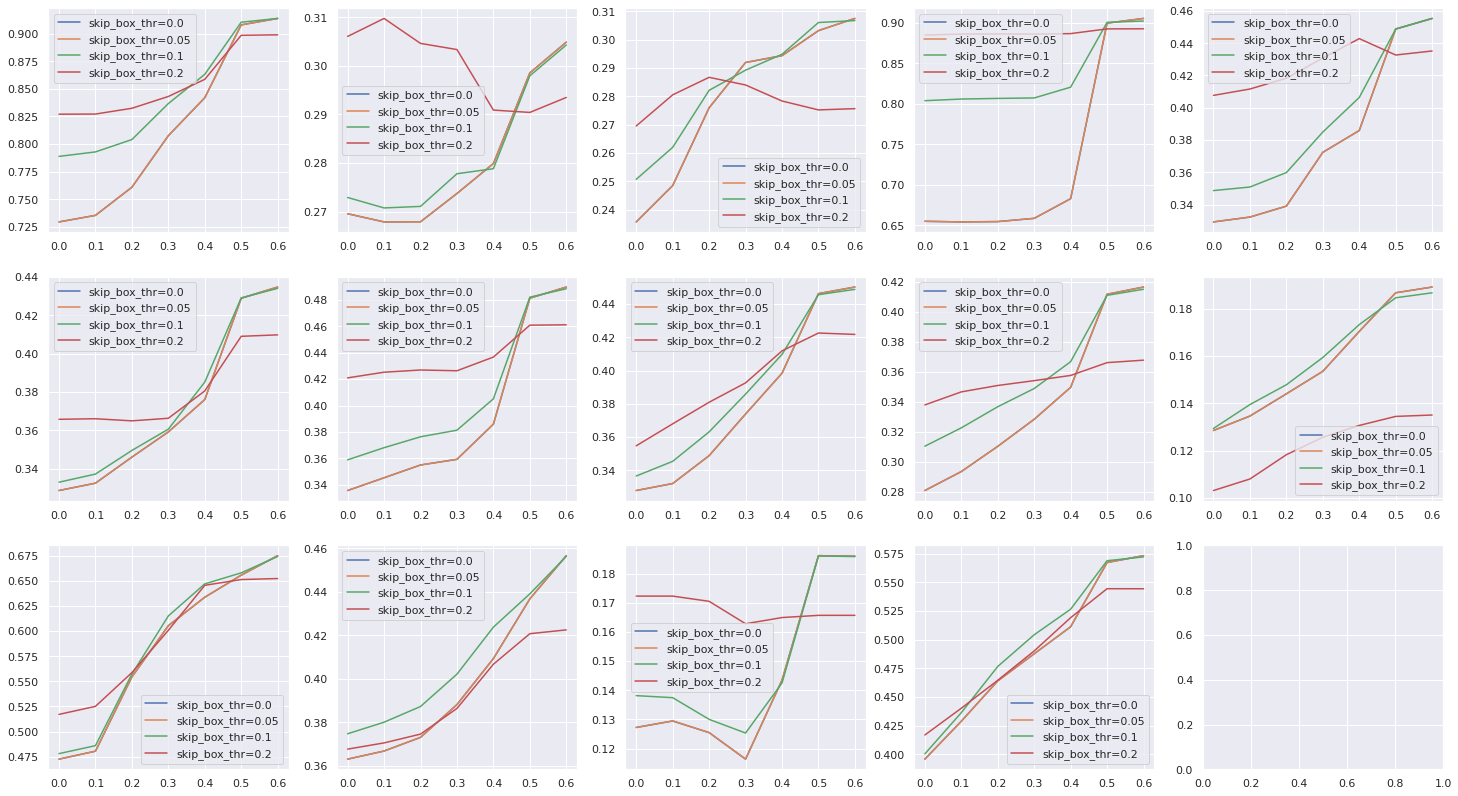

In [37]:
fig, axes = plt.subplots(3, 5, figsize=(25, 14))
axes = axes.flatten()
for cls_id, cls_nm in enumerate(classes_nms):
    cls_result = a[cls_id]
    for i, skip_box_thr in enumerate(skip_box_thrs):
        y = cls_result[:, i, :].mean(axis=1)
        axes[cls_id].plot(iou_thrs, y, label=f'skip_box_thr={skip_box_thr}')
    axes[cls_id].legend()
plt.show()

In [41]:
pickle.dump(results_by_models, open(str(base_dir / 'stack.pkl'), 'wb'))

In [39]:
model_dir = 'retinanet_R_101_FPN_3x_mkf_5_1024'

if '256' in result_dir:
    img_size = 256
elif '512' in result_dir:
    img_size = 512
elif '1024' in result_dir:
    img_size = 1024
else:
    raise ValueError()

if 'nms01' in result_dir:
    iou_thr = 0.1
else:
    iou_thr = 0.5

rm_str = '_rm' if rm else ''
train = pickle.load(open(str(base_dir / f'nms{iou_thr}_train_{img_size}{rm_str}.pkl'), 'rb'))
dataset_dicts = pickle.load(open(str(base_dir / f'nms{iou_thr}_dataset_dicts_{img_size}{rm_str}.pkl'), 'rb'))
mkf = pickle.load(open(str(base_dir / f'nms{iou_thr}_mkf_{img_size}{rm_str}.pkl'), 'rb'))

pred_df_list, evaluator_list = load(mkf, dataset_dicts, train, result_dir)

Generating image data...
Generating category data...
Generating annotation data...
Generating image data...
Generating category data...
Generating annotation data...
Generating image data...
Generating category data...
Generating annotation data...
Generating image data...
Generating category data...
Generating annotation data...
Generating image data...
Generating category data...
Generating annotation data...


In [40]:
for fold in 

,image_id,PredictionString
0,2229148faa205e881cf0d932755c9e40,11 0.5404967665672302 235 130 423 200 11 0.517...
1,9c41221ce46d36fc44d140e21c3f3da7,10 0.7293806076049805 135 150 465 744 3 0.6762...
2,7a7b30a642d5f305ccf5f7a6f2e901e8,5 0.4383848309516907 628 474 792 813 11 0.4333...
3,01d6446afde9fbf4332904bc331e9660,0 0.7991705536842346 515 172 628 298 3 0.74255...
4,30c34393c4ba548104b8a65aa2fd76bb,0 0.8103620409965515 528 238 629 356 3 0.39248...
...,...,...
854,98d31d7df7863752c8f85cd0be34ecc5,3 0.6756210923194885 335 484 791 613 0 0.67522...
855,2b0fb0afde2742c14c1c967cdcb20969,0 0.7688136696815491 491 282 597 373 3 0.73165...
856,407530901f066b6b5b5d486495617fc8,13 0.4506663680076599 553 123 746 402 11 0.375...
857,e645d9985d6afaacf2722b9c82b2c9c5,3 0.49676957726478577 443 423 823 548 13 0.441...


## Evaluation

In [44]:
grid_evals = pickle.load(open(str(base_dir / 'stack-11.pkl'), 'rb'))

In [55]:
y

array([0.86679995, 0.83433329, 0.86291695, 0.88100954, 0.86673991])

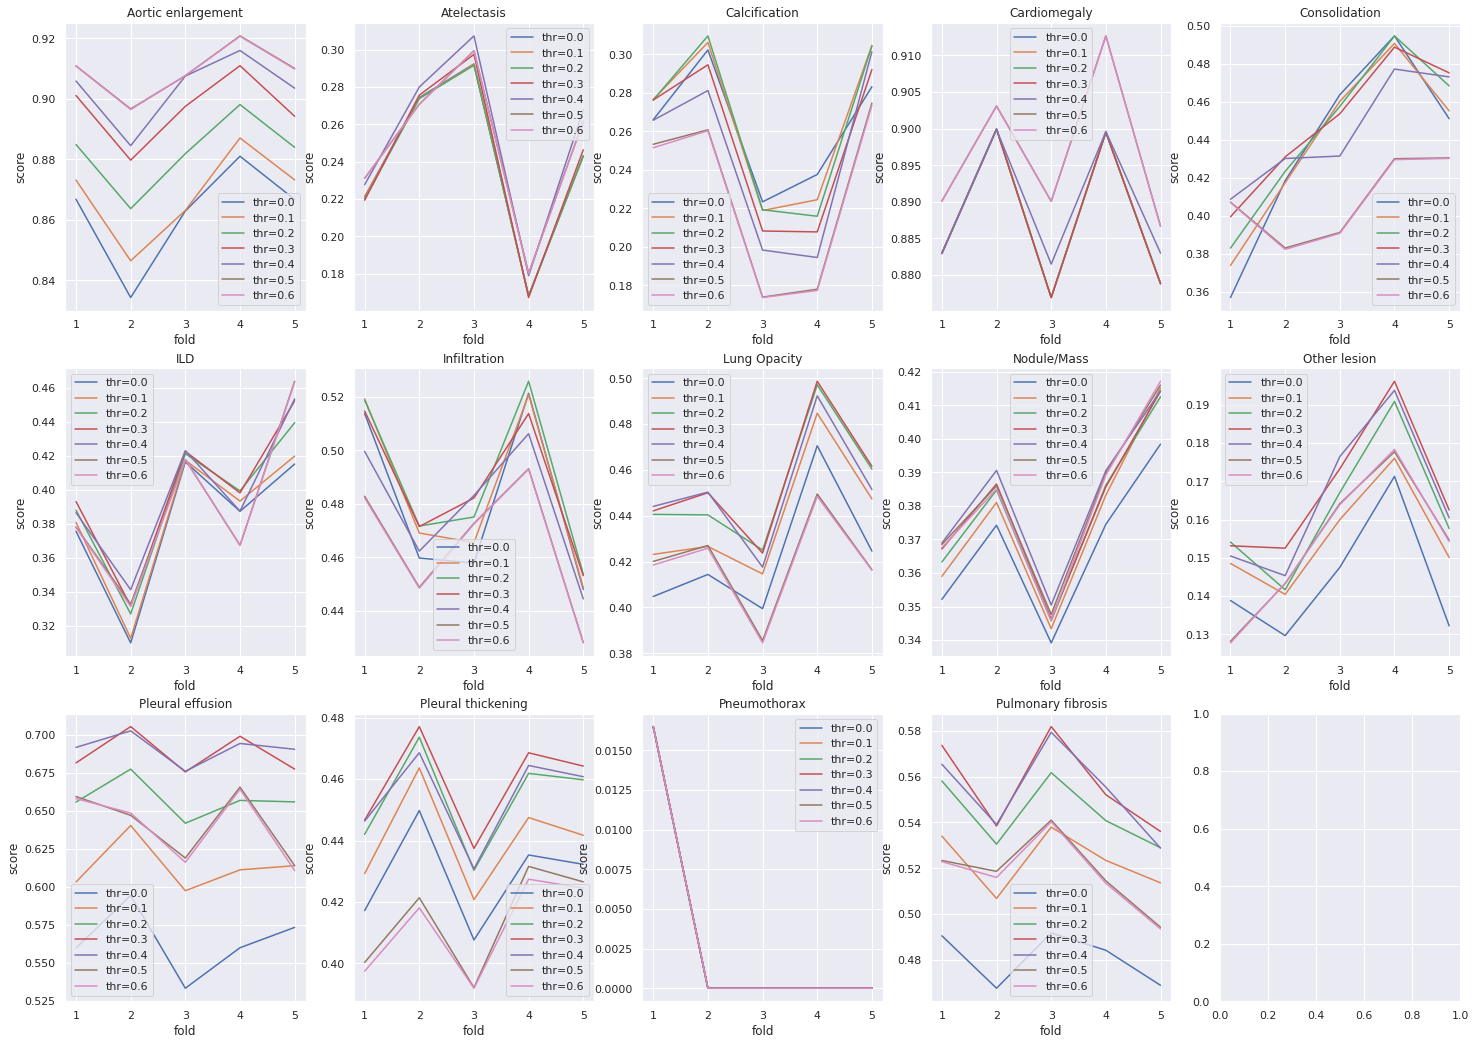

In [59]:
model_idx = 0

fig, axes = plt.subplots(3, 5, figsize=(25, 18))
axes = axes.flatten()
for cls_id, (cls_nm, ax) in enumerate(zip(classes_nms, axes)):
    cls_results = np.array(grid_evals['results'][model_idx])[cls_id]
    for iou_thr, y in zip([0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6], cls_results):
        ax.plot([1, 2, 3, 4, 5], y, label=f'thr={iou_thr}')
    ax.legend()
    ax.set_ylabel('score')
    ax.set_xlabel('fold')
    ax.set_title(cls_nm)
plt.show()